# EPFL Machine Learning Higgs

## Loading and preprocessing

In [1]:
import math
%load_ext autoreload
%autoreload 2

import os
import csv
import numpy as np
from helpers import load_data, one_hot_encode, standardize

In [2]:
data_directory = '../data'
train_dataset_path = os.path.join(data_directory, 'train.csv')
public_test_dataset_path = os.path.join(data_directory, 'test.csv')

# Loading the data
_, Y_train_public, feature_names, X_train_public = load_data(train_dataset_path)
ids_test_public, _, _, X_test_public = load_data(public_test_dataset_path)

In [3]:
# We need to deal with -999 somehow (missing values)
# First of all, we make sure they do not contribute to computing the mean and std
# Since they are floats, we add an epsilon against numerical errors
EPSILON = 1E-4
mask_train = np.abs(X_train_public + 999) <= EPSILON
mask_test = np.abs(X_test_public + 999) <= EPSILON

X_train_public[mask_train] = np.nan
X_test_public[mask_test] = np.nan

print('Proportion of missing values:', np.sum(mask_train)/(mask_train.shape[0]*mask_train.shape[1]))
print('Proportion of missing values:', np.sum(mask_test)/(mask_test.shape[0]*mask_test.shape[1]))

Proportion of missing values: 0.2106736
Proportion of missing values: 0.21050064702935506


In [5]:
# We will standardize the data based on the mean and standard deviation of the public train dataset
# It ignores NaN values for computing the mean and std for the standardization
# ! The method standardizes in-place !
continuous_column_idxs = np.where(feature_names != "PRI_jet_num")[0]
column_means, column_stds = standardize(X_train_public, continuous_column_idxs)
_, _ = standardize(X_test_public, continuous_column_idxs, column_means, column_stds)

# Finally, we set the NaNs to the mean of the standardized dataset, namely, 0
X_train_public = np.nan_to_num(X_train_public, nan=0.0)
X_test_public = np.nan_to_num(X_test_public, nan=0.0)

In [6]:
# Then we will need to notice the discrete-valued column, since this needs to be one-hot encoded
# In our dataset, only "PRI_jet_num" is discrete.
discrete_column_idxs = np.where(feature_names == "PRI_jet_num")[0]

# Update the features by one-hot encoding the discrete ones, but only update the feature names at the end
# They will be the same for the train and test set anyway
X_train_public, _ = one_hot_encode(X_train_public, discrete_column_idxs, feature_names)
X_test_public, feature_names = one_hot_encode(X_test_public, discrete_column_idxs, feature_names)

In [8]:
# We will need to add interaction terms to deal with co-linearity somewhere (like x1*x2 instead of just x1 and x2)
covariance_matrix = np.cov(X_train_public, rowvar=False)
co_linear_threshold = 0.7
co_linear_feature_columns = []
for i in range(len(covariance_matrix)):
    for j in range(i+1, len(covariance_matrix)):
        if np.abs(covariance_matrix[i][j]) >= co_linear_threshold:
            co_linear_feature_columns.append((i, j))

print('Found', len(co_linear_feature_columns), 'possible co-linear feature pairs')

Found 8 possible co-linear feature pairs


In [9]:
X_public_co_linear_features = None
for f1_idx, f2_idx in co_linear_feature_columns:
    new_feature_column = np.expand_dims(X_train_public[:, f1_idx] * X_train_public[:, f2_idx], axis=1)
    if X_public_co_linear_features is None:
        X_public_co_linear_features = new_feature_column
    else:
        X_public_co_linear_features = np.concatenate((X_public_co_linear_features, new_feature_column), axis=1)

X_test_co_linear_features = None
for f1_idx, f2_idx in co_linear_feature_columns:
    new_feature_column = np.expand_dims(X_test_public[:, f1_idx] * X_test_public[:, f2_idx], axis=1)
    if X_test_co_linear_features is None:
        X_test_co_linear_features = new_feature_column
    else:
        X_test_co_linear_features = np.concatenate((X_test_co_linear_features, new_feature_column), axis=1)

X_train_public = np.concatenate((X_train_public, X_public_co_linear_features), axis=1)
X_test_public = np.concatenate((X_test_public, X_test_co_linear_features), axis=1)

In [10]:
# Since this is a binary classification problem, we do not need to one-hot encode the y-vector, but we can just use binary values
positive_sample = 's'
negative_sample = 'b'
Y_train_public = np.expand_dims((Y_train_public == positive_sample).astype(np.int32), axis=1)

# ! There are quite some more positive than negative samples, maybe we could try to weigh negative samples more or something? !
print('Number of positive samples:', np.sum(Y_train_public))
print('Number of negative samples:', len(Y_train_public) - np.sum(Y_train_public))

Number of positive samples: 85667
Number of negative samples: 164333


# Training and analysis

After preprocessing, the new features of the public train- and test dataset are stored in "X_train_public" and "X_test_public". The labels are binary values stored in "Y_train_public". Furthermore, the feature column names are found in "feature_names"

In [11]:
# We will do k-fold cross validation to create subsets of the training and testing datasets
print(feature_names)
print(X_train_public.shape, X_test_public.shape)
print(Y_train_public.shape)

['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' 'PRI_tau_pt'
 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi'
 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_leading_pt'
 'PRI_jet_leading_eta' 'PRI_jet_leading_phi' 'PRI_jet_subleading_pt'
 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi' 'PRI_jet_all_pt'
 'PRI_jet_num_0' 'PRI_jet_num_1' 'PRI_jet_num_2' 'PRI_jet_num_3']
(250000, 41) (568238, 41)
(250000, 1)


In [12]:
from helpers import train_test_split
from implementations import reg_logistic_regression

X_train, X_test, Y_train, Y_test = train_test_split(X_train_public, Y_train_public, train_proportion=0.7)

w, loss = reg_logistic_regression(Y_train, X_train, lambda_=0, initial_w=np.zeros(shape=(X_train.shape[1], 1)), max_iters=1000, gamma=0.1)
print('GD loss:', loss)
print('Weights:', w)

100%|██████████| 1000/1000 [00:45<00:00, 21.88it/s]

GD loss: 0.45705496788622396
Weights: [[ 6.05555265e-01]
 [-7.49257162e-01]
 [-3.70099071e-01]
 [ 1.78046449e-01]
 [ 9.13120365e-02]
 [ 4.01376584e-01]
 [-3.38195325e-02]
 [ 6.78531965e-01]
 [-6.81795884e-04]
 [ 1.63432187e-01]
 [-4.82768552e-01]
 [ 2.47112879e-01]
 [ 3.23305420e-01]
 [ 5.06609557e-01]
 [-7.74137784e-03]
 [-5.50517125e-04]
 [ 5.91414729e-01]
 [ 1.31570497e-03]
 [ 5.00444524e-03]
 [ 4.39090172e-02]
 [ 5.07388348e-03]
 [-6.67939357e-02]
 [ 9.74122665e-02]
 [-2.28107432e-03]
 [-5.02640640e-03]
 [ 1.46556280e-01]
 [ 1.36311164e-04]
 [-1.00889962e-02]
 [-5.60479910e-02]
 [-4.87422794e-01]
 [-4.76923601e-01]
 [-4.71673503e-02]
 [-4.12255076e-01]
 [-9.87452331e-01]
 [-1.71427613e-01]
 [ 1.21045054e-02]
 [ 1.97234166e-01]
 [-2.02153548e-01]
 [-1.51768852e-03]
 [ 4.26243858e-02]
 [-8.20246865e-03]]


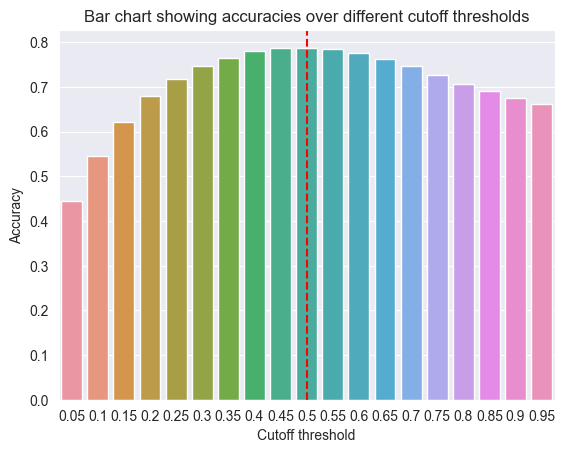

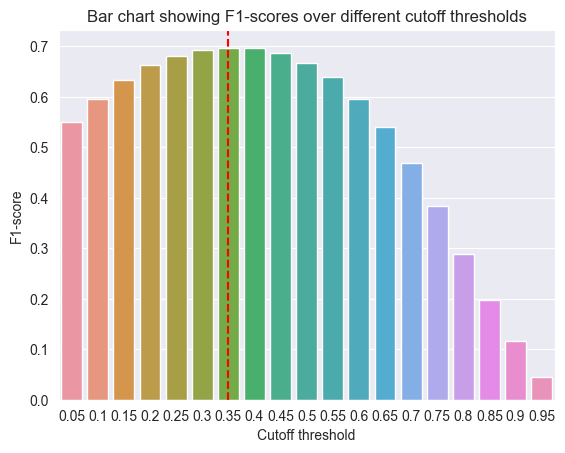

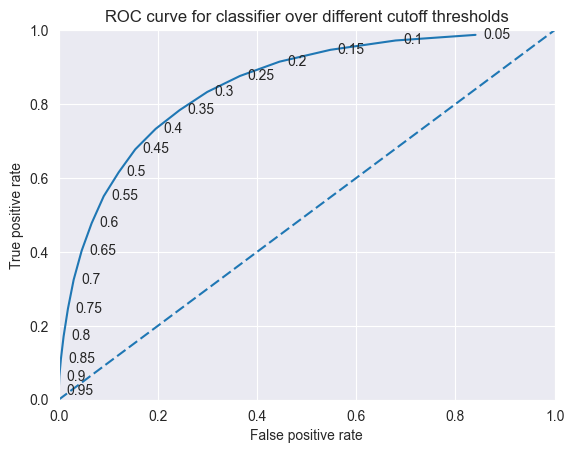

In [13]:
# Now we can evaluate the training
# ! We can actually also do some hyperparameter tuning (using ROC curves to determine the right cut-off probability) !

# Note ROC curves do not work well for linear regression, since there could be values that are not between 0 and 1!
# In this temporary example I just clip the predictions between 0 and 1

from metrics import confusion_matrix_statistics, LogisticRegressionLoss
import matplotlib.pyplot as plt
import seaborn as sns

num_values = 20
cutoff_values = [(i+1)/num_values for i in range(num_values-1)]

accuracies = []
f1_scores = []
tprs = []
fprs = []

for cutoff_value in cutoff_values:
    predictions = (LogisticRegressionLoss.sigmoid(X_test @ w) > cutoff_value).astype(np.int32)
    tp, fp, fn, tn, accuracy, tpr, _, f1_score, fpr = confusion_matrix_statistics(predictions, Y_test)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)
    tprs.append(tpr)
    fprs.append(fpr)

plt.figure()
ax = sns.barplot(x=cutoff_values, y=accuracies)
largest_idx = np.argmax(accuracies)
plt.axvline(x=largest_idx, ymin=0, ymax=1, linestyle='dashed', color='red')
ax.set(title='Bar chart showing accuracies over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='Accuracy')
plt.show()

plt.figure()
largest_idx = np.argmax(f1_scores)
plt.axvline(x=largest_idx, ymin=0, ymax=1, linestyle='dashed', color='red')
ax = sns.barplot(x=cutoff_values, y=f1_scores)
ax.set(title='Bar chart showing F1-scores over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='F1-score')
plt.show()

plt.figure()
ax = sns.lineplot(x=fprs, y=tprs, legend=False)
ax.set(title='ROC curve for classifier over different cutoff thresholds', xlabel='False positive rate', ylabel='True positive rate', xlim=(0, 1), ylim=(0, 1))
ax.axline((0, 0), slope=1, dashes=(5, 2))
for i in range(len(tprs)):
    if i % math.ceil(0.05*len(cutoff_values)) == 0:
        plt.text(x=fprs[i]+0.015,y=tprs[i]-0.01, s=str(round(cutoff_values[i], 2)))
plt.show()

In [91]:
# Testing linear regression
from implementations import ridge_regression

X_train, X_test, Y_train, Y_test = train_test_split(X_train_public, Y_train_public, train_proportion=0.5)

w, loss = ridge_regression(Y_train, X_train, lambda_=0)

# Do predictions with cutoff of 0.5
predictions = X_test @ w
cutoff = 0.5
predictions = (predictions > cutoff).astype(np.int32)
# Mean 0-1 loss
test_loss = np.sum(np.abs(Y_test - predictions)) / Y_test.shape[0]

combined = np.append(Y_test, predictions, axis=0)
n_signal = np.sum(Y_test)
n_background = Y_test.shape[0] - n_signal
correct_predictions_signal = np.sum(predictions * Y_test)
correct_predictions_background = np.sum((predictions + Y_test) == 0)
wrong_predictions_signal = n_signal - correct_predictions_signal
wrong_predictions_background = n_background - correct_predictions_background
print(f'''
Test loss / Mean 0-1 loss: {test_loss},
Number of signal entries: {n_signal},
Number of background entries: {n_background}
Correct predictions of signal: {correct_predictions_signal},
Correct predictions of background: {correct_predictions_background}
Signals correctly predicted: {float(correct_predictions_signal) / n_signal}
Backgrounds correctly predicted: {float(correct_predictions_background) / n_background}
''')



Test loss / Mean 0-1 loss: 0.321304,
Number of signal entries: 42943,
Number of background entries: 82057
Correct predictions of signal: 20430,
Correct predictions of background: 64407
Signals correctly predicted: 0.4757469203362597
Backgrounds correctly predicted: 0.7849056143899972



The mean 0-1 loss can be interpreted as the probability of making a wrong classification using linear regression. Setting the cutoff rate manually to 0.5, we observe an 25% probability of making a wrong prediction. The signals are predicted correctly in 87% of the cases, but the background only in 50% of the cases. This can be due to the relative frequency of the cases in the dataset. The effect can be tried out by equalizing the number of the signal and background entries in the data set.

Further tasks:
- Equalize the size of the signal and the background rows in the training (and possibly testing) datasets
- Experiment with different cutoff rates to see if they improve the classification result

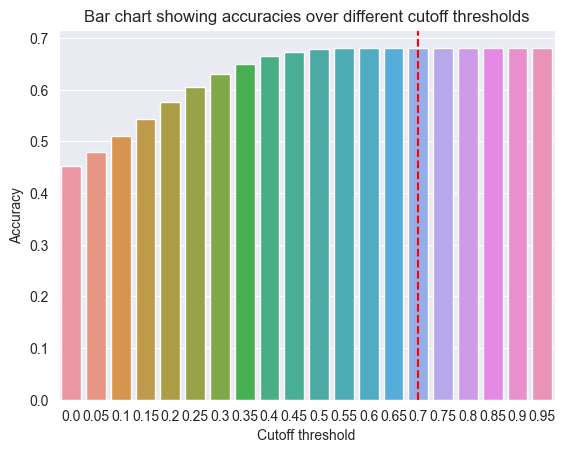

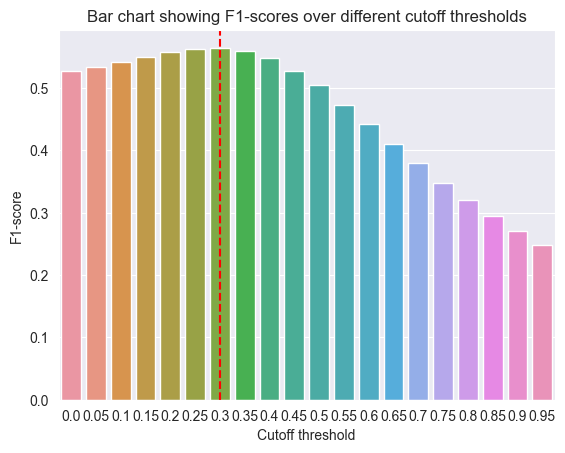

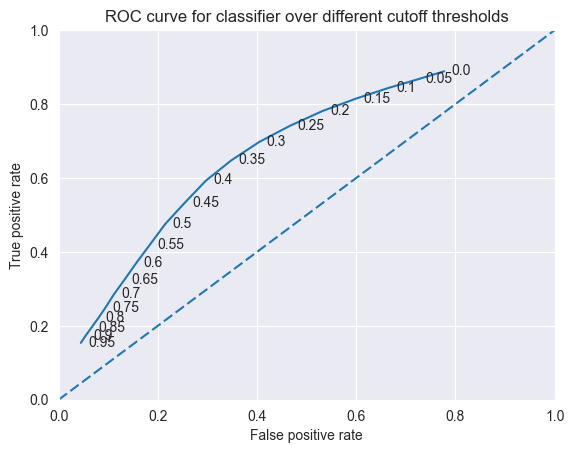

In [92]:
n_cutoff = 20
cutoff_values = np.round_(np.linspace(0, 1, num=n_cutoff, endpoint=False),2)

accuracies = []
f1_scores = []
tprs = []
fprs = []

for cutoff_value in cutoff_values:
    predictions = (X_test @ w > cutoff_value).astype(np.int32)
    tp, fp, fn, tn, accuracy, tpr, _, f1_score, fpr = confusion_matrix_statistics(predictions, Y_test)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)
    tprs.append(tpr)
    fprs.append(fpr)


plt.figure()
ax = sns.barplot(x=cutoff_values, y=accuracies)
largest_idx = np.argmax(accuracies)
plt.axvline(x=largest_idx, ymin=0, ymax=1, linestyle='dashed', color='red')
ax.set(title='Bar chart showing accuracies over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='Accuracy')
plt.show()

plt.figure()
largest_idx = np.argmax(f1_scores)
plt.axvline(x=largest_idx, ymin=0, ymax=1, linestyle='dashed', color='red')
ax = sns.barplot(x=cutoff_values, y=f1_scores)
ax.set(title='Bar chart showing F1-scores over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='F1-score')
plt.show()

plt.figure()
ax = sns.lineplot(x=fprs, y=tprs, legend=False)
ax.set(title='ROC curve for classifier over different cutoff thresholds', xlabel='False positive rate', ylabel='True positive rate', xlim=(0, 1), ylim=(0, 1))
ax.axline((0, 0), slope=1, dashes=(5, 2))
for i in range(len(tprs)):
    if i % math.ceil(0.05*len(cutoff_values)) == 0:
        plt.text(x=fprs[i]+0.015,y=tprs[i]-0.01, s=str(round(cutoff_values[i], 2)))
plt.show()

0.55 seems to be the optimal cutoff threshold for accuracy.

0.45 seems to be the optimal cutoff threshold for F1-score.

0.5 seems to be a sweet spot with respect to both of them.

In [78]:
# Create predictions with linear regression
predictions = X_test_public @ w
cutoff = 0.5
predictions = (predictions > cutoff).astype(np.int32)
n_test = X_test_public.shape[0]
n_signal = predictions[predictions == 1].shape[0]
n_background = predictions[predictions == 0].shape[0]
print(f"""Signal in: {n_signal} cases ({n_signal / n_test * 100}%),
Background in {n_background} cases({ n_background / n_test * 100}%),
In total {X_test_public.shape[0]} data points""")

submission_file_name = 'submission_linregr.csv'
with open(os.path.join(data_directory, submission_file_name), mode='w', newline='', encoding='utf-8') as submission_file:
    writer = csv.writer(submission_file, delimiter=',')
    writer.writerow(['Id', 'Prediction'])
    for i, prediction in enumerate(predictions):
        writer.writerow([ids_test_public[i], 1 if prediction else -1])


Signal in: 425084 cases (74.80738704556893%),
Background in 143154 cases(25.192612954431066%),
In total 568238 data points


In [43]:
def plot_train_test(train_errors, test_errors, lambdas):
    """
    train_errors, test_errors and lambas should be list (of the same size) the respective train error and test error for a given lambda,
    * lambda[0] = 1
    * train_errors[0] = RMSE of a ridge regression on the train set
    * test_errors[0] = RMSE of the parameter found by ridge regression applied on the test set
    
    degree is just used for the title of the plot.
    """
    plt.semilogx(lambdas, train_errors, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, test_errors, color='r', marker='*', label="Test error")
    plt.xlabel("lambda")
    plt.ylabel("RMSE")
    plt.title("Ridge regression results")
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)

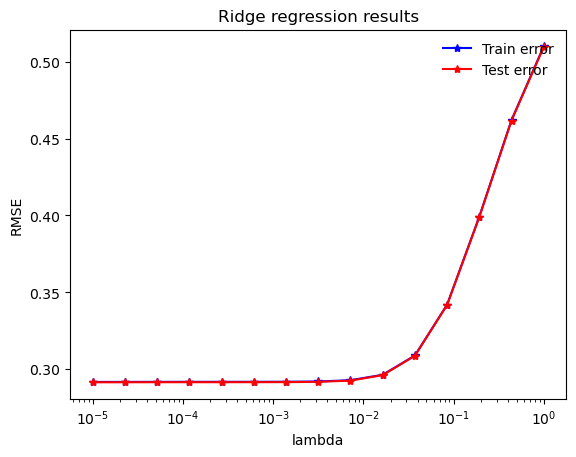

In [44]:
# Evaluating Ridge regression
from metrics import (
    RidgeLoss
)

def test_ridge_regression(x, y, ratio):
    
    lambdas = np.logspace(-5, 0, 15)
    x_tr, x_te, y_tr, y_te = train_test_split(x, y, train_proportion=ratio)
    rmse_tr = []
    rmse_te = []

    for ind, lambda_ in enumerate(lambdas):
        w, loss = ridge_regression(y_tr, x_tr, lambda_)
        rmse_tr.append(np.sqrt(loss))
        rmse_te.append(np.sqrt(RidgeLoss.loss(x_te, y_te, w)))
    
    plot_train_test(rmse_tr, rmse_te, lambdas)

test_ridge_regression(X_train_public, Y_train_public, 0.5)

For ridge regression the regularization does not seem to improve the test error. Thus, for ridge regression, using the standard linear regression is best for classification.

# Inference

In [11]:
# Placeholder, array with True of False whether it belongs to the positive or negative sample
best_cutoff = 0.35

predictions = (LogisticRegressionLoss.sigmoid(X_test_public @ w) > best_cutoff).astype(np.int32)

submission_file_name = 'submission_0.csv'
with open(os.path.join(data_directory, submission_file_name), mode='w', newline='', encoding='utf-8') as submission_file:
    writer = csv.writer(submission_file, delimiter=',')
    writer.writerow(['Id', 'Prediction'])
    for i, prediction in enumerate(predictions):
        writer.writerow([ids_test_public[i], 1 if prediction else -1])
